In [14]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN

In [15]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [16]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_shape = (batch_size, 3, 32, 32)
num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


In [17]:
from Models import LeNet

input_shape = (batch_size, 3, 32, 32)
num_labels = 10 

LeNN = LeNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Flatten: 2-9                      [100, 1024]               --
│    └─Linear: 2-10                      [100, 120]                123,000
│    └─Tanh: 2-11                        [100, 120]                --
│    └

In [18]:
criterion = CrossEntropyLoss()

train_NN(LeNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 1.988
test_loss: 1.867, test_accuracy: 34.22
[1,   200] train_loss: 1.795
test_loss: 1.744, test_accuracy: 37.23
[1,   300] train_loss: 1.712
test_loss: 1.658, test_accuracy: 40.24
[1,   400] train_loss: 1.659
test_loss: 1.611, test_accuracy: 42.41
[1,   500] train_loss: 1.616
test_loss: 1.542, test_accuracy: 44.45
[2,   100] train_loss: 1.546
test_loss: 1.545, test_accuracy: 44.96
[2,   200] train_loss: 1.535
test_loss: 1.542, test_accuracy: 45.71
[2,   300] train_loss: 1.515
test_loss: 1.469, test_accuracy: 47.37
[2,   400] train_loss: 1.469
test_loss: 1.491, test_accuracy: 47.04
[2,   500] train_loss: 1.450
test_loss: 1.463, test_accuracy: 47.95
[3,   100] train_loss: 1.392
test_loss: 1.445, test_accuracy: 48.95
[3,   200] train_loss: 1.416
test_loss: 1.441, test_accuracy: 49.2
[3,   300] train_loss: 1.421
test_loss: 1.402, test_accuracy: 49.64
[3,   400] train_loss: 1.371
test_loss: 1.402, test_accuracy: 50.78
[3,   500] train_loss: 1.387
test_loss: 1.381, te

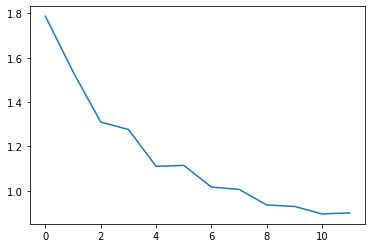

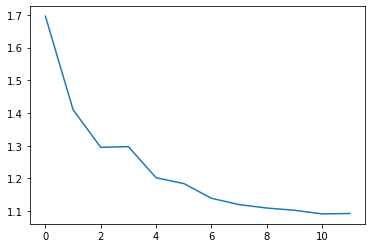

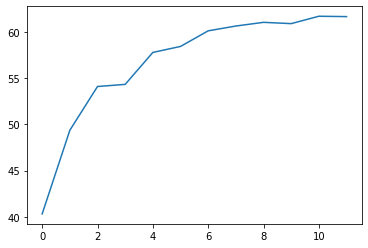

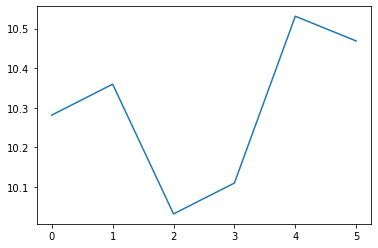

In [11]:
plt.plot(leStats[0])
plt.show()
plt.plot(leStats[1])
plt.show()
plt.plot(leStats[2])
plt.show()
plt.plot(leStats[3])
plt.show()

In [19]:
from Models import LeASLNet

input_shape = (batch_size, 3, 32, 32)

LeASLNN = LeASLNet(input_shape, 10, device, expansion_rate=1)

summary(LeASLNN, input_shape)

TypeError: LeASLNet.__init__() missing 3 required positional arguments: 'momentum', 'weight_decay', and 'device'

In [13]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeASLNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [14]:
leASLStats = train_NN(LeASLNN, train_dataloader,
        test_dataloader, epochs=6, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 1.803
test_loss: 1.566, test_accuracy: 42.71
[1,   400] train_loss: 1.564
test_loss: 1.474, test_accuracy: 46.63
[2,   200] train_loss: 1.337
test_loss: 1.348, test_accuracy: 51.24
[2,   400] train_loss: 1.323
test_loss: 1.323, test_accuracy: 52.03
[3,   200] train_loss: 1.193
test_loss: 1.256, test_accuracy: 55.11
[3,   400] train_loss: 1.192
test_loss: 1.245, test_accuracy: 56.04
[4,   200] train_loss: 1.096
test_loss: 1.207, test_accuracy: 57.21
[4,   400] train_loss: 1.086
test_loss: 1.212, test_accuracy: 57.32
[5,   200] train_loss: 1.020
test_loss: 1.192, test_accuracy: 58.23
[5,   400] train_loss: 1.024
test_loss: 1.182, test_accuracy: 58.32
[6,   200] train_loss: 0.993
test_loss: 1.173, test_accuracy: 58.55
[6,   400] train_loss: 0.985
test_loss: 1.175, test_accuracy: 58.58


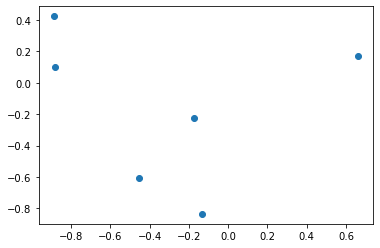

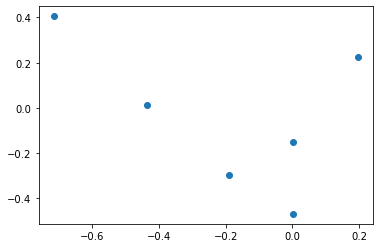

In [19]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [24]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, 10, device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Depth_wise_block: 2-5             [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─Tanh: 2-10                        [100, 120]                --
│    └─L

In [25]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeDepthNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [26]:
leDepthStats = train_NN(LeDepthNN, train_dataloader,
        test_dataloader, epochs=6, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 1.885
test_loss: 1.736, test_accuracy: 38.15
[1,   400] train_loss: 1.607
test_loss: 1.587, test_accuracy: 42.83
[2,   200] train_loss: 1.369
test_loss: 1.370, test_accuracy: 51.55
[2,   400] train_loss: 1.347
test_loss: 1.311, test_accuracy: 53.34
[3,   200] train_loss: 1.194
test_loss: 1.258, test_accuracy: 55.7
[3,   400] train_loss: 1.176
test_loss: 1.268, test_accuracy: 55.73
[4,   200] train_loss: 1.095
test_loss: 1.225, test_accuracy: 56.83
[4,   400] train_loss: 1.081
test_loss: 1.210, test_accuracy: 57.73
[5,   200] train_loss: 1.020
test_loss: 1.202, test_accuracy: 58.11
[5,   400] train_loss: 1.022
test_loss: 1.198, test_accuracy: 58.19
[6,   200] train_loss: 0.977
test_loss: 1.193, test_accuracy: 58.23
[6,   400] train_loss: 0.977
test_loss: 1.196, test_accuracy: 58.3


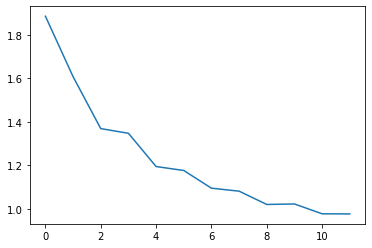

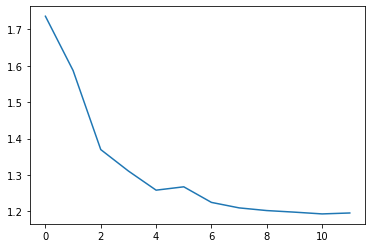

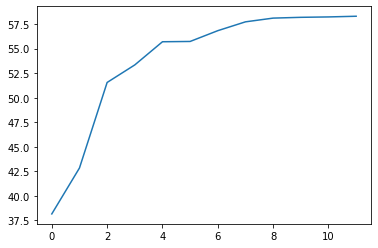

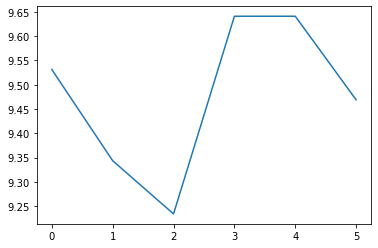

In [27]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()

In [1]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

NameError: name 'train_dataloader' is not defined

In [5]:
from Models import Cifar10_Net

input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN_cif = Cifar10_Net(input_shape, num_labels, expansion_rate, device)

summary(NN_cif, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_Net                              [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 26, 26]         4,736
│    └─CSC_block: 2-2                    [100, 64, 26, 26]         --
│    │    └─Sequential: 3-1              --                        19,520
│    └─CSC_block: 2-3                    [100, 128, 26, 26]        --
│    │    └─Sequential: 3-2              --                        75,904
│    └─AvgPool2d: 2-4                    [100, 128, 3, 3]          --
│    └─Flatten: 2-5                      [100, 1152]               --
│    └─Linear: 2-6                       [100, 64]                 73,792
│    └─ReLU: 2-7                         [100, 64]                 --
│    └─Linear: 2-8                       [100, 10]                 650
Total params: 174,602
Trainable params: 174,602
Non-trainable params:

In [6]:
PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN_cif.load_state_dict(torch.load(PATH))
    NN_cif.eval()

In [7]:
criterion = CrossEntropyLoss()
optimizer_Cifar = optim.SGD(NN_cif.parameters(), lr=0.05, momentum=0.9)
scheduler_Cifar = optim.lr_scheduler.ExponentialLR(optimizer_Cifar, gamma=0.9)

In [9]:
%%timeit
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Cifar.zero_grad()

        # forward + backward + optimize
        outputs = NN_cif(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_Cifar.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_cif, test_dataloader, criterion, device))

    scheduler_Cifar.step()

[1,   244] train_loss: 4.071
(1.4727221763134002, 47.23)


In [10]:
torch.save(NN_cif.state_dict(), "./models/Cifar/Cifar10.pth")

In [8]:
from Models import Cifar10_Net

criterion = CrossEntropyLoss()


input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN2_cif = Cifar10_Net(input_shape, num_labels, expansion_rate)


PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN2_cif.load_state_dict(torch.load(PATH))
    NN2_cif.eval()

print(test_loss(NN2_cif, test_dataloader, criterion))

(1.413678903579712, 49.93)
